In [107]:
include("../code/bp_full.jl")
include("../code/bp.jl")
using Distributions, StatsBase, Base.Threads

In [75]:
function ms_rein(n, f1, f2, s; verbose=true, maxiter=10^2, rein=1e-3)
    f3 = 1 - f1 -f2
    Lambda = [f1,f2,f3]
    K = [0,0,1]
    nedges = Int(round(n*sum(i*l for (i,l) in pairs(Lambda)), digits=10))
    m = Int(nedges/3)
    r = 1 - m/n
    efield = [(si,-si).+ 1e-5.*(randn(),randn()) for si in s]
    ms = bp_full(n, m, nedges, Lambda, K, efield)
    ε, iters = iteration_ms!(ms; maxiter, rein)
    nunsat, ovl, dist = performance(ms, s)
#     @show nunsat, ovl, dist
    H = ms.H; Ht = permutedims(H)
    d = if nunsat!=0
        B,indep = findbasis_slow(Array(H))
        x = argmax.(ms.belief) .== 2
        σ = fix_indep!(x, B, indep)   
        distortion(σ,s)
    else
        dist
    end
    r, d, nunsat
end

ms_rein (generic function with 1 method)

## Vary ε

In [86]:
nflippeds = 1:n÷40:n÷3
ds = zeros(length(nflippeds))
rs = similar(ds)
nunsats = zeros(Int, length(nflippeds))

f1 = 0.0
f2 = 0.5

@showprogress for i in eachindex(nflippeds)
#     println("## Trial $i of ", length(nflippeds))
    nflipped = nflippeds[i]
    s = ones(n)
    s[sample(1:n, nflipped, replace=false)] .= -1
    rs[i], ds[i], nunsats[i] = ms_rein(n, f1, f2, s; maxiter=5*10^2, rein=1e-3, verbose=true)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


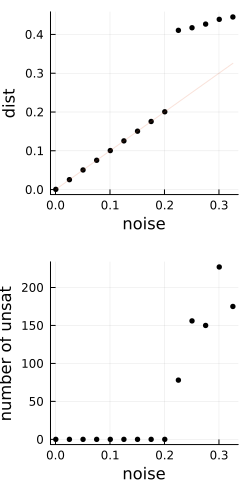

In [91]:
pl1 = scatter(nflippeds ./ n, ds, label="", xlabel="noise", ylabel="dist", c=:black, ms=3)
plot!(pl1, identity, linealpha=0.2, label="", size=(300,300))
pl2 = scatter(nflippeds ./ n, nunsats, label="", xlabel="noise", ylabel="number of unsat", c=:black, ms=3)
plot(pl1, pl2, layout=(2,1), size=(250,500))

## Average over instances

In [132]:
navg = 50
nflippeds = 1:n÷40:n÷3
ds = [zeros(navg) for _ in nflippeds]
rs = [zeros(navg) for _ in nflippeds]
nunsats = [zeros(Int, navg) for _ in nflippeds]

f1 = 0.0
f2 = 0.5

@threads for a in 1:navg
    for i in eachindex(nflippeds)
        nflipped = nflippeds[i]
        s = ones(n)
        s[sample(1:n, nflipped, replace=false)] .= -1
        rs[i][a], ds[i][a], nunsats[i][a] = ms_rein(n, f1, f2, s; maxiter=5*10^2, rein=1e-3, verbose=true)
    end
end

In [133]:
ds_avg = mean.(ds)
ds_std = std.(ds) ./ sqrt(navg)
nunsats_avg = mean.(nunsats)
nunsats_std = std.(nunsats) ./ sqrt(navg);

In [135]:
include("../code/plotters/approx_entropy.jl")
R = rs[1][1]
D = H2inv(1-R)

0.26441329303114275

In [153]:
using DelimitedFiles
open("planted.txt", "w") do f
    writedlm(f, n)
    writedlm(f, nflippeds')
    writedlm(f, D)
   writedlm(f, [ ds_avg ds_std nunsats_avg nunsats_std]) 
end

In [142]:
Plots.default(
    grid = false,
    size = (400,400),
#    fontfamily="sans-serif",     
    fontfamily="serif-roman",     # "serif-roman" is the closest thing to latex i could find
    markerstrokewidth = 1,        # border around dots
    markersize = 3
)

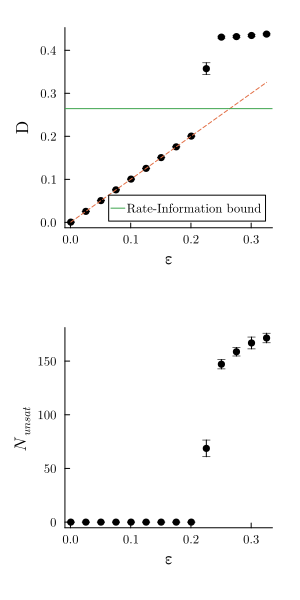

In [149]:
pl1 = scatter(nflippeds ./ n, ds_avg, yerr=ds_std, label="", xlabel="ε", ylabel="D", c=:black, ms=4)
plot!(pl1, identity, linealpha=1, label="", size=(300,300), ls=:dash)
hline!(pl1, [D], label="Rate-Information bound", legend=:bottomright)
pl2 = scatter(nflippeds ./ n, nunsats_avg, yerr = nunsats_std, label="", xlabel="ε", 
    ylabel="\$ N_{unsat}\$", c=:black, ms=4)
plot(pl1, pl2, layout=(2,1), size=(300,600), margin=5Plots.mm)